# Description

This notebook runs some pre-analyses using spectral clustering to explore the best set of parameters to cluster `umap` data version.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

2

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=2
env: OPEN_BLAS_NUM_THREADS=2
env: NUMEXPR_NUM_THREADS=2
env: OMP_NUM_THREADS=2


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 50000

# UMAP

In [6]:
INPUT_SUBSET = "umap"

In [7]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
DR_OPTIONS = {
    "n_components": 50,
    "metric": "euclidean",
    "n_neighbors": 15,
    "random_state": 0,
}

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/umap/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0.pkl')

'umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3752, 50)

In [12]:
data.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP41,UMAP42,UMAP43,UMAP44,UMAP45,UMAP46,UMAP47,UMAP48,UMAP49,UMAP50
100001_raw-Food_weight,9.587280,8.050184,9.340894,8.884522,4.562011,9.261327,9.078164,8.009141,9.288872,9.827831,...,9.753575,0.440851,-0.077164,-0.184829,9.345852,0.622542,-0.051136,4.266558,8.047482,-0.317385
100002_raw-Energy,9.910512,8.372274,9.605316,9.808598,4.641970,9.360196,8.848985,7.768594,9.231921,9.328465,...,9.647689,0.581584,0.547930,0.600128,8.976416,1.249645,0.234843,4.636343,7.173085,0.137119
100003_raw-Protein,9.923088,8.380640,9.609899,9.836457,4.647365,9.366775,8.835996,7.767549,9.230281,9.314386,...,9.642637,0.580362,0.565898,0.621073,8.967297,1.271435,0.243960,4.648671,7.149967,0.148192
100004_raw-Fat,9.898531,8.375697,9.600443,9.785713,4.639249,9.360721,8.886237,7.783376,9.237095,9.345434,...,9.648270,0.573073,0.521042,0.576926,8.979161,1.227988,0.231848,4.622777,7.205517,0.147385
100005_raw-Carbohydrate,9.895807,8.376662,9.605841,9.791338,4.636903,9.352356,8.867312,7.774787,9.233479,9.344456,...,9.652949,0.575161,0.529565,0.579919,8.988125,1.231771,0.226778,4.624360,7.194818,0.123104


# Clustering

In [13]:
from sklearn.cluster import SpectralClustering

from clustering.utils import compute_performance

## `gamma` parameter

### Using default value (`gamma=1.0`)

In [14]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=1.00,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

In [15]:
# show number of clusters and their size
_tmp = pd.Series(part).value_counts()
display(_tmp)
assert _tmp.shape[0] == 2
assert _tmp.loc[1] == 8

0    3744
1       8
dtype: int64

In [16]:
# show some clustering performance measures to assess the quality of the partition
_tmp = compute_performance(data, part)
assert 0.20 < _tmp["si"] < 0.25
assert 10.0 < _tmp["ch"] < 15.00
assert 0.70 < _tmp["db"] < 0.80

'Silhouette (higher is better): 0.205'

'Calinski-Harabasz (higher is better): 13.462'

'Davies-Bouldin (lower is better): 0.740'

For default values of `gamma` (`1.0`), the algorithm takes a lot of time to converge (here I used `eigen_tol=1e-03` to force convergence).

### Using `gamma>1.0` (larger than default value)

In [17]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=2.50,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

In [18]:
# show number of clusters and their size
_tmp = pd.Series(part).value_counts()
display(_tmp)
assert _tmp.shape[0] == 2
assert _tmp.loc[1] == 14

0    3738
1      14
dtype: int64

In [19]:
# show some clustering performance measures to assess the quality of the partition
_tmp = compute_performance(data, part)
assert 0.01 < _tmp["si"] < 0.03
assert 10.0 < _tmp["ch"] < 13.00
assert 1.00 < _tmp["db"] < 1.10

'Silhouette (higher is better): 0.022'

'Calinski-Harabasz (higher is better): 12.053'

'Davies-Bouldin (lower is better): 1.050'

For default values of `gamma` (`1.0`), the algorithm takes a lot of time to converge (here I used `eigen_tol=1e-03` to force convergence).

Also, all quality measures go down.

### Using `gamma==0.1`

In [20]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=0.1,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

In [21]:
# show number of clusters and their size
_tmp = pd.Series(part).value_counts()
display(_tmp)
assert _tmp.shape[0] == 2
assert _tmp.loc[1] == 8

0    3744
1       8
dtype: int64

In [22]:
# show some clustering performance measures to assess the quality of the partition
_tmp = compute_performance(data, part)
assert 0.70 < _tmp["si"] < 0.80
assert 215.0 < _tmp["ch"] < 225.00
assert 0.15 < _tmp["db"] < 0.20

'Silhouette (higher is better): 0.761'

'Calinski-Harabasz (higher is better): 220.724'

'Davies-Bouldin (lower is better): 0.181'

For `gamma` values around `0.1`, clustering quality measures improve. I will explore more around these values.

### Using `gamma==0.01`

In [23]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=1,
        affinity="rbf",
        gamma=0.01,
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(data)

In [24]:
# show number of clusters and their size
_tmp = pd.Series(part).value_counts()
display(_tmp)
assert _tmp.shape[0] == 2
assert _tmp.loc[1] > 1000

1    1926
0    1826
dtype: int64

In [25]:
# show some clustering performance measures to assess the quality of the partition
_tmp = compute_performance(data, part)
assert 0.30 < _tmp["si"] < 0.40
assert 1800.0 < _tmp["ch"] < 1810.00
assert 1.20 < _tmp["db"] < 1.30

'Silhouette (higher is better): 0.356'

'Calinski-Harabasz (higher is better): 1802.399'

'Davies-Bouldin (lower is better): 1.242'

For `gamma` values around `0.01`, some clustering quality measures improve a lot. I will explore more around these values.

## Extended test

Here I run some test across several `k` and `gamma` values; then I check how results perform with different clustering quality measures.

In [26]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = [2, 4, 6, 8, 10, 20, 30, 40, 50, 60]
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10
CLUSTERING_OPTIONS["GAMMAS"] = [
    1.00,
    1e-01,
    1e-02,
    1e-03,
    #     1e-04,
    #     1e-05,
    1e-05,
    #     1e-06,
    #     1e-07,
    #     1e-08,
    #     1e-09,
    1e-10,
    #     1e-11,
    #     1e-12,
    #     1e-13,
    #     1e-14,
    1e-15,
    #     1e-17,
    1e-20,
    #     1e-30,
    #     1e-40,
    1e-50,
]
CLUSTERING_OPTIONS["AFFINITY"] = "rbf"

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2, 4, 6, 8, 10, 20, 30, 40, 50, 60],
 'N_REPS_PER_K': 5,
 'KMEANS_N_INIT': 10,
 'GAMMAS': [1.0, 0.1, 0.01, 0.001, 1e-05, 1e-10, 1e-15, 1e-20, 1e-50],
 'AFFINITY': 'rbf'}

In [27]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    for gamma_value in CLUSTERING_OPTIONS["GAMMAS"]:
        for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
            clus = SpectralClustering(
                eigen_solver="arpack",
                n_clusters=k,
                n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
                affinity=CLUSTERING_OPTIONS["AFFINITY"],
                gamma=gamma_value,
                random_state=random_state,
            )

            method_name = type(clus).__name__
            CLUSTERERS[f"{method_name} #{idx}"] = clus

            random_state = random_state + 1
            idx = idx + 1

In [28]:
display(len(CLUSTERERS))

450

In [29]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('SpectralClustering #0',
 SpectralClustering(eigen_solver='arpack', n_clusters=2, random_state=50000))

('SpectralClustering #1',
 SpectralClustering(eigen_solver='arpack', n_clusters=2, random_state=50001))

In [30]:
clustering_method_name = method_name
display(clustering_method_name)

'SpectralClustering'

## Generate ensemble

In [31]:
import tempfile
from clustering.ensembles.utils import generate_ensemble

In [34]:
ensemble = generate_ensemble(
    data,
    CLUSTERERS,
    attributes=["n_clusters", "gamma"],
)

'Ensemble file exists'

In [35]:
ensemble.shape

(450, 4)

In [36]:
ensemble.head()

,clusterer_params,partition,n_clusters,gamma
clusterer_id,,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0


In [37]:
ensemble["gamma"] = ensemble["gamma"].apply(lambda x: f"{x:.1e}")

In [38]:
ensemble["n_clusters"].value_counts()

60    45
50    45
40    45
30    45
20    45
10    45
8     45
6     45
4     45
2     45
Name: n_clusters, dtype: int64

In [39]:
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"] * len(CLUSTERING_OPTIONS["GAMMAS"])
)

In [40]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    450.000000
mean      23.000000
std       19.846291
min        2.000000
25%        6.000000
50%       15.000000
75%       40.000000
max       60.000000
Name: n_clusters, dtype: float64

## Testing

In [41]:
assert ensemble_stats["min"] > 1

In [42]:
assert not ensemble["n_clusters"].isna().any()

In [43]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [44]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [45]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])
assert not np.any(
    [pd.Series(part["partition"]).isna().any() for idx, part in ensemble.iterrows()]
)

In [46]:
# check that the number of clusters in the partitions are the expected ones
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
display(_real_k_values)
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

clusterer_id
SpectralClustering #0       2
SpectralClustering #1       2
SpectralClustering #2       2
SpectralClustering #3       2
SpectralClustering #4       2
                           ..
SpectralClustering #445    60
SpectralClustering #446    60
SpectralClustering #447    60
SpectralClustering #448    60
SpectralClustering #449    60
Name: partition, Length: 450, dtype: int64

## Add clustering quality measures

In [47]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

In [48]:
ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(lambda x: silhouette_score(data, x)),
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x)),
    db_score=ensemble["partition"].apply(lambda x: davies_bouldin_score(data, x)),
)

In [49]:
ensemble.shape

(450, 7)

In [50]:
ensemble.head()

,clusterer_params,partition,n_clusters,gamma,si_score,ch_score,db_score
clusterer_id,,,,,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,0.760892,220.723951,0.180785
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,0.760892,220.723951,0.180785
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,0.760892,220.723951,0.180785
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,0.642472,137.751690,0.281444
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1.0e+00,0.760892,220.723951,0.180785


# Cluster quality

In [51]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

si_score     ch_score   db_score
n_clusters gamma                                    
2          1.0e+00  0.737208   204.129499   0.200917
           1.0e-01  0.760892   220.723951   0.180785
           1.0e-02  0.355970  1802.139767   1.242860
           1.0e-03  0.355432  1799.298165   1.244803
           1.0e-05  0.355273  1798.797039   1.244884
           1.0e-10  0.355252  1798.728715   1.244897
           1.0e-15  0.295295  1370.804365   1.442880
           1.0e-20 -0.003585     8.492178   5.583933
           1.0e-50  0.033921     7.557833   7.311003
4          1.0e+00  0.380782   236.332514   0.684431
           1.0e-01  0.592782   288.784209   0.292268
           1.0e-02  0.403670  1837.196352   0.780045
           1.0e-03  0.403886  1838.512027   0.779507
           1.0e-05  0.403960  1838.906287   0.779419
           1.0e-10  0.403948  1839.383598   0.779452
           1.0e-15  0.150354   668.704738   3.592202
           1.0e-20 -0.132109     3.552747  10.267282
           1.0e-50 -0.140442     3.604253  12.124735
6          1.0e+00  0.309967   654.458253   0.722936
           1.0e-01  0.414453  1617.238043   0.547346
           1.0e-02  0.414201  1618.080894   0.548320
           1.0e-03  0.414316  1619.050251   0.547391
           1.0e-05  0.414290  1619.019054   0.547496
           1.0e-10  0.414291  1618.888341   0.547480
           1.0e-15  0.002891   347.091734   4.272685
           1.0e-20 -0.258445     4.538158   8.387075
           1.0e-50 -0.252697     4.101857   9.259601
8          1.0e+00  0.360253  1519.622234   0.724993
           1.0e-01  0.405399  2394.645154   0.591619
           1.0e-02  0.317558  1715.082777   0.925498
           1.0e-03  0.323471  1704.770835   0.871630
           1.0e-05  0.322992  1694.431081   0.871746
           1.0e-10  0.322858  1694.130462   0.872624
           1.0e-15 -0.065555   298.860606   4.735972
           1.0e-20 -0.262420     3.632985   8.081872
           1.0e-50 -0.299957     3.768735   8.777887
10         1.0e+00  0.386720  2134.915902   0.615309
           1.0e-01  0.358440  2437.956089   0.699226
           1.0e-02  0.352622  2348.184254   0.682433
           1.0e-03  0.314438  2021.944674   0.762487
           1.0e-05  0.276087  1793.807638   0.923043
           1.0e-10  0.265376  1737.989389   0.978456
           1.0e-15 -0.102864   238.870062   6.036939
           1.0e-20 -0.403800     3.635720  11.347886
           1.0e-50 -0.298386     3.377175  10.487996
20         1.0e+00  0.358755  2385.805168   0.667338
           1.0e-01  0.300602  1905.445946   0.815706
           1.0e-02  0.269410  1774.805988   0.869132
           1.0e-03  0.259895  1807.009872   0.987256
           1.0e-05  0.269236  1794.941653   1.011296
           1.0e-10  0.259188  1777.307309   1.006639
           1.0e-15 -0.280934   111.578643   7.041359
           1.0e-20 -0.494335     2.654543   9.811520
           1.0e-50 -0.493106     2.297930   9.408050
30         1.0e+00  0.331762  2346.354222   0.745231
           1.0e-01  0.279018  1898.930652   0.959470
           1.0e-02  0.259548  1521.900735   1.030722
           1.0e-03  0.250242  1470.995193   1.041829
           1.0e-05  0.249042  1475.199272   0.999475
           1.0e-10  0.248728  1443.151605   1.016645
           1.0e-15 -0.331779    72.438774   6.976948
           1.0e-20 -0.585442     3.262004   9.946241
           1.0e-50 -0.594790     2.085268   9.374759
40         1.0e+00  0.323718  2069.164791   0.727407
           1.0e-01  0.283146  1783.261466   0.895995
           1.0e-02  0.262163  1457.406960   1.132600
           1.0e-03  0.258422  1227.402037   1.384333
           1.0e-05  0.243850  1136.979308   0.885598
           1.0e-10  0.239151  1135.378822   1.116398
           1.0e-15 -0.532449    42.089852   6.937359
           1.0e-20 -0.631351     1.719154   9.452124
           1.0e-50 -0.655213     2.040446   9.133605
50         1.0e+00  0.307431  1985.728605   0.809585
           1.0e-01  0.260506  1569.296011   0

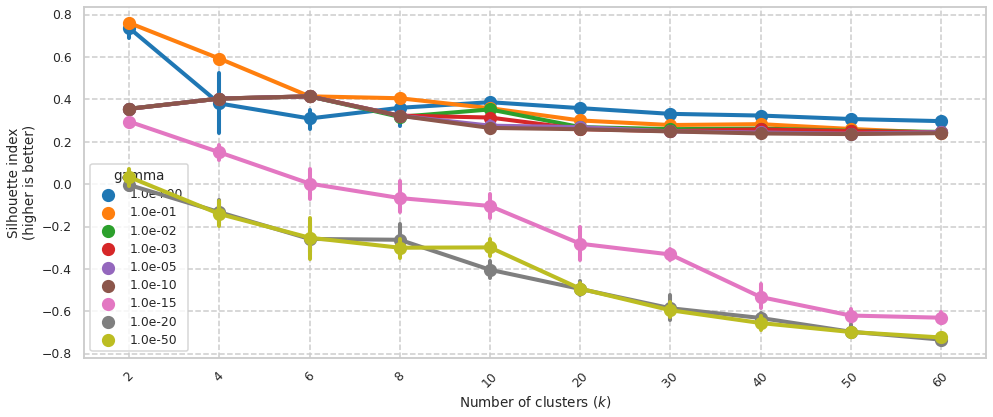

In [52]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score", hue="gamma")
    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

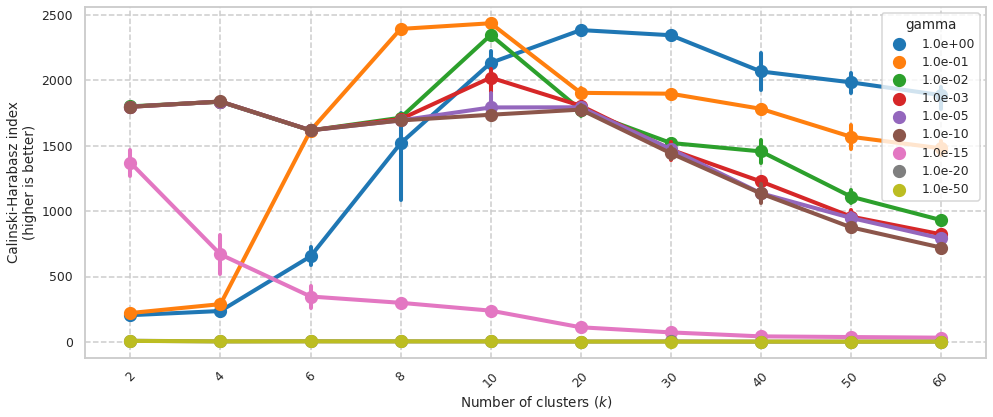

In [53]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score", hue="gamma")
    ax.set_ylabel("Calinski-Harabasz index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

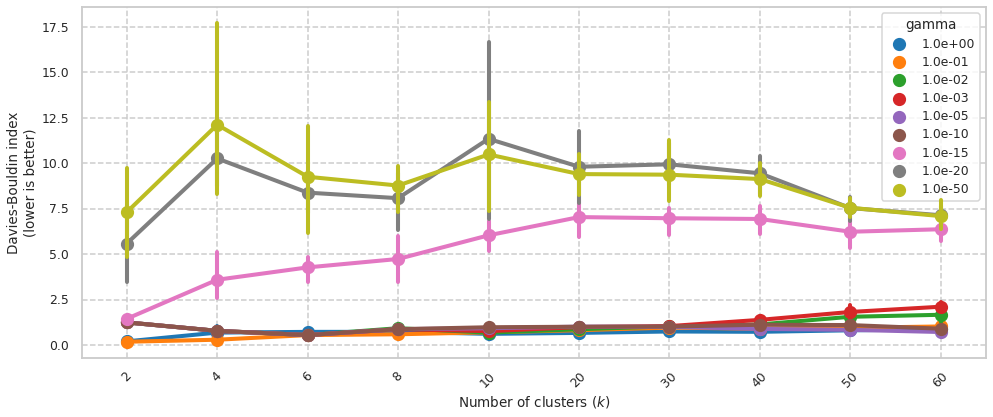

In [54]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="db_score", hue="gamma")
    ax.set_ylabel("Davies-Bouldin index\n(lower is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [55]:
parts = ensemble.groupby(["gamma", "n_clusters"]).apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [56]:
parts.shape

(90,)

In [57]:
parts.head()

gamma    n_clusters
1.0e+00  2             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         4             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
         6             [[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...
         8             [[0.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...
         10            [[4.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0,...
dtype: object

In [58]:
parts.iloc[0].shape

(5, 3752)

In [59]:
assert np.all(
    [
        parts.loc[k].shape == (int(CLUSTERING_OPTIONS["N_REPS_PER_K"]), data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [60]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [61]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="n_clusters"
)

In [62]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

1.0e-02  4    1.000000
1.0e-01  2    1.000000
1.0e-05  8    1.000000
1.0e-10  6    1.000000
1.0e-01  4    1.000000
1.0e-03  2    1.000000
         8    0.999651
1.0e-02  2    0.999574
1.0e-10  2    0.999147
1.0e-05  2    0.998721
1.0e-10  8    0.998590
1.0e-03  6    0.997581
1.0e-05  6    0.995750
1.0e-02  8    0.995729
1.0e-03  4    0.993542
Name: n_clusters, dtype: float64

In [63]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)
parts_ari_df.index.rename(["gamma", "n_clusters"], inplace=True)

In [64]:
parts_ari_df.shape

(90, 10)

In [65]:
_n_total_parts = int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"]
)  # * len(CLUSTERING_OPTIONS["GAMMAS"]))

assert int(_n_total_parts * (_n_total_parts - 1) / 2) == parts_ari_df.shape[1]

In [66]:
parts_ari_df.head()

0         1         2         3         4  \
gamma   n_clusters                                                     
1.0e+00 2           1.000000  1.000000 -0.002553  1.000000  1.000000   
        4           1.000000  0.943176  0.943176  0.880462  0.943176   
        6           0.205895  0.037030  0.210272  0.988538  0.211135   
        8           0.767037  0.327605  0.768014  0.605952  0.363211   
        10          0.987851  0.785262  0.988594  0.987851  0.779218   

                           5         6         7         8         9  
gamma   n_clusters                                                    
1.0e+00 2          -0.002553  1.000000 -0.002553  1.000000 -0.002553  
        4           0.943176  0.880462  1.000000  0.943176  0.943176  
        6           0.989574  0.205426  0.211135  0.036907  0.209798  
        8           0.998537  0.645096  0.363016  0.625943  0.644873  
        10          0.999255  1.000000  0.779393  0.779218  0.999255

## Stability plot

In [67]:
parts_ari_df_plot = (
    parts_ari_df.stack().reset_index().rename(columns={"level_2": "idx", 0: "ari"})
)

In [68]:
parts_ari_df_plot.dtypes

gamma          object
n_clusters      int64
idx             int64
ari           float64
dtype: object

In [69]:
parts_ari_df_plot.head()

,gamma,n_clusters,idx,ari
0,1.0e+00,2,0,1.000000
1,1.0e+00,2,1,1.000000
2,1.0e+00,2,2,-0.002553
3,1.0e+00,2,3,1.000000
4,1.0e+00,2,4,1.000000


In [70]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = parts_ari_df_plot.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

idx       ari
n_clusters gamma                 
2          1.0e+00  4.5  0.598979
           1.0e-01  4.5  1.000000
           1.0e-02  4.5  0.999574
           1.0e-03  4.5  1.000000
           1.0e-05  4.5  0.998721
           1.0e-10  4.5  0.999147
           1.0e-15  4.5  0.476849
           1.0e-20  4.5 -0.001848
           1.0e-50  4.5 -0.000742
4          1.0e+00  4.5  0.941998
           1.0e-01  4.5  1.000000
           1.0e-02  4.5  1.000000
           1.0e-03  4.5  0.993542
           1.0e-05  4.5  0.983088
           1.0e-10  4.5  0.975570
           1.0e-15  4.5  0.306471
           1.0e-20  4.5 -0.000222
           1.0e-50  4.5  0.005633
6          1.0e+00  4.5  0.330571
           1.0e-01  4.5  0.945920
           1.0e-02  4.5  0.979481
           1.0e-03  4.5  0.997581
           1.0e-05  4.5  0.995750
           1.0e-10  4.5  1.000000
           1.0e-15  4.5  0.241371
           1.0e-20  4.5  0.002722
           1.0e-50  4.5  0.007581
8          1.0e+00  4.5  0.610928
           1.0e-01  4.5  0.973618
           1.0e-02  4.5  0.995729
           1.0e-03  4.5  0.999651
           1.0e-05  4.5  1.000000
           1.0e-10  4.5  0.998590
           1.0e-15  4.5  0.211176
           1.0e-20  4.5  0.003329
           1.0e-50  4.5 -0.000862
10         1.0e+00  4.5  0.908590
           1.0e-01  4.5  0.979824
           1.0e-02  4.5  0.983728
           1.0e-03  4.5  0.876920
           1.0e-05  4.5  0.885715
           1.0e-10  4.5  0.985148
           1.0e-15  4.5  0.218076
           1.0e-20  4.5 -0.000272
           1.0e-50  4.5  0.002074
20         1.0e+00  4.5  0.991550
           1.0e-01  4.5  0.864392
           1.0e-02  4.5  0.737274
           1.0e-03  4.5  0.877688
           1.0e-05  4.5  0.812753
           1.0e-10  4.5  0.833580
           1.0e-15  4.5  0.180379
           1.0e-20  4.5  0.001049
           1.0e-50  4.5 -0.007294
30         1.0e+00  4.5  0.988657
           1.0e-01  4.5  0.797207
           1.0e-02  4.5  0.761040
           1.0e-03  4.5  0.758884
           1.0e-05  4.5  0.773429
           1.0e-10  4.5  0.771107
           1.0e-15  4.5  0.186106
           1.0e-20  4.5  0.001765
           1.0e-50  4.5  0.001274
40         1.0e+00  4.5  0.727106
           1.0e-01  4.5  0.733349
           1.0e-02  4.5  0.723044
           1.0e-03  4.5  0.721083
           1.0e-05  4.5  0.768981
           1.0e-10  4.5  0.728810
           1.0e-15  4.5  0.113212
           1.0e-20  4.5  0.002067
           1.0e-50  4.5  0.000274
50         1.0e+00  4.5  0.732695
           1.0e-01  4.5  0.690632
           1.0e-02  4.5  0.644430
           1.0e-03  4.5  0.730778
           1.0e-05  4.5  0.757627
           1.0e-10  4.5  0.757236
           1.0e-15  4.5  0.135947
           1.0e-20  4.5  0.007621
           1.0e-50  4.5 -0.000234
60         1.0e+00  4.5  0.752237
           1.0e-01  4.5  0.632544
           1.0e-02  4.5  0.724925
           1.0e-03  4.5  0.755408
           1.0e-05  4.5  0.774084
           1.0e-10  4.5  0.714725
           1.0e-15  4.5  0.169836
           1.0e-20  4.5  0.006333
           1.0e-50  4.5 -0.000381

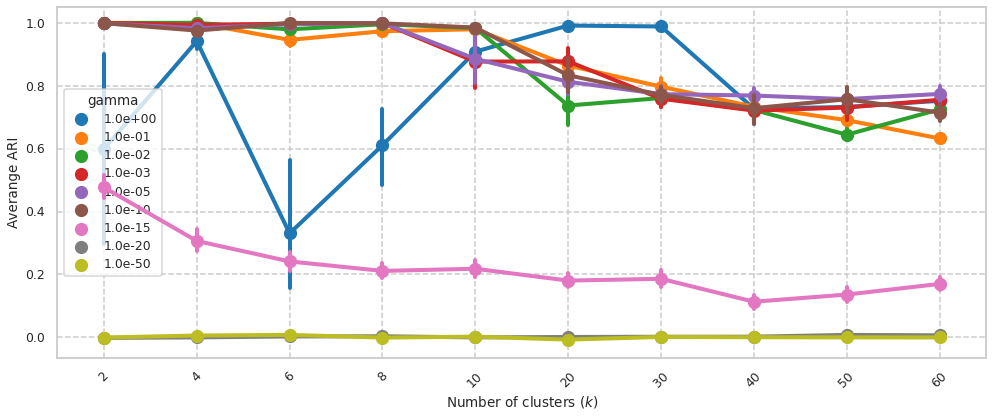

In [71]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="n_clusters", y="ari", hue="gamma")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Conclusions

**UPDATE** We choose `1e-10` as the `gamma` parameter for this data version.